# Stock Assets Analyser

This notebook will implement the stockutils module to analyse user stock transaction history.

In [1]:
from stockutils import readers as sur
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,10

In [2]:
testMode = False

In [3]:
# TODO: embed on module

class AssetQuantityRange:
    def __init__(self, startDate, endDate, assets):
        self.startDate = startDate # start of range, incluse
        self.endDate = endDate # start of range, exclusive
        self.quantity = {}
        
        for asset in assets:
            self.quantity[asset] = 0
            
    def __str__(self):
        return "[startDate = {}, endDate = {}, {}".format(self.startDate, self.endDate,
            ["{}: {} ".format(key, self.quantity[key]) for key in self.quantity.keys()])

    def __repr__(self):
        return str(self)

In [4]:
def underSampleSeries(xdata, ydata, factor):
    """
    Reduces the number of x and y samples by the given factor.
    
    Parameters
    ----------
    xdata: list
        list of labels. No algebraic operation will be done on this data, 
        only 'factor-1' for every 'factor' points will be dropped.
    
    ydata: list 
        list of values (int or float), every 'factor' samples will be 
        combined into one.
    
    Raises
    ----------
    ValueError
        If lengths of xdata and ydata differ.
    
    Return
    ----------
    newxdata: list
        List of new x data.
        
    newydata: list
        List of new y data.
    """
    if len(xdata) != len(ydata):
        raise ValueError('length of xdata and ydata should match')
    
    newxdata = []
    newydata = []
    
    for c in range(0, int(len(xdata)/factor)):
        # new xdata point should the middle point of each factor length block
        newxdata.append(xdata[factor*c + int(factor/2)])
        
        # new ydata will be the average of 'factor' samples
        newysample = 0
        for i in range(0, factor):
            newysample += ydata[c*factor + i]
        newysample /= factor
        
        newydata.append(newysample)
        
    return newxdata, newydata

In [5]:
def plotTwoCurves(dateRange, setA, setALabel, setB, setBLabel, undersamplefactor=1):
    
    newdateRange, newsetA = underSampleSeries(dateRange, setA, undersamplefactor)
    _, newsetB = underSampleSeries(dateRange, setB, undersamplefactor)
    
    fig, ax1 = plt.subplots()

    # Stock value
    color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel(setALabel, color=color)
    ax1.plot(newdateRange, newsetA, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # IBOV index
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(setBLabel, color=color)
    ax2.plot(newdateRange, newsetB, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
    plt.show()

In [6]:
def calculateDailyPortifolioValue(days, assetDayQuantity, stockPrice):
    """
    Calculates the portifolio value for a range of days, given the executed transactions for that 
    period and the daily asset values.
    
    Parameters
    ----------
    days: list
        List of days as strings in "YYYYMMDD".
    
    assetDayQuantity: list
        List of AssetQuantityRange, representing quantities for each asset over the period comprehended
        by the days list.
        
    stockPrice: dict
        Dictionary with ticker strings as keys where each entry is a dictionary of prices with days 
        (strings in "YYYYMMDD" format) as keys.
        
    Return
    ----------
    dailyportifoliovalue: dict
        Dictionary of float values. The keys are strings in "YYYYMMDD" format and each value represents
        the portifolio value for that day.
    """
    
    dailyportifoliovalue = {}
    
    firstRun = True
    for adq in assetDayQuantity:
        # calculate days before first transaction
        if firstRun:
            for dayIndex in range(0, days.index(adq.startDate)):
                dailyportifoliovalue[days[dayIndex]] = 0
            firstRun = False

        for dayIndex in range(days.index(adq.startDate), days.index(adq.endDate)):
            sum = 0
            for asset in assets:
                try:
                    qtty = adq.quantity[asset]
                    if qtty is not 0:
                        price = stockPrice[asset][days[dayIndex]]
                        sum += qtty * price
                except:
                    print('error for asset {}, day {}'.format(asset, days[dayIndex]))

            dailyportifoliovalue[days[dayIndex]] = sum

    # calculate last day of dataset
    sum = 0
    for asset in assets:
        qtty = adq.quantity[asset]
        price = stockPrice[asset][days[-1]]
        sum += qtty * price

    dailyportifoliovalue[days[-1]] = sum
    
    return dailyportifoliovalue

In [20]:
def calculateDailyAssetQuantity(days, assets, transactions):
    """
    Calculates quantity of assets over time.
    
    Parameters
    ----------
    days: list
        List of days as strings in "YYYYMMDD".
        
    assets: list
        List of assets (as strings) present in at least one transaction.
    
    transactions: dict 
        Dictionary of lists of transactions. The keys of the dictionary are dates ("YYYYMMDD" format)
        and the lists represents all the transactions for that day.
    
    Return
    ----------
    assetDayQuantity: list
        List of AssetQuantityRange, ordered by crescent date. Each instance of AssetQuantityRange
        represents a fixed quantity of each asset for a given period of time.
    """
    assetDayQuantity = []
    
    transactionDays = [str(d) for d in transactions.keys()]

    # create first entry for days before first transaction
    if len(transactionDays) != 0:
        lastAqr = AssetQuantityRange(days[0], transactionDays[0], assets)
        assetDayQuantity.append(lastAqr)

        for i in range(0, len(transactionDays)):
            aqr = AssetQuantityRange(transactionDays[i], days[-1], assets)
            dayTransactions = transactions[transactionDays[i]]

            if i != len(transactionDays) - 1:
                aqr.endDate = transactionDays[i+1]

            # compute variation of that day
            for t in dayTransactions:
                aqr.quantity[t.ticker] += (t.buyQtty - t.sellQtty)

            # add variation to last value
            for asset in assets:
                aqr.quantity[asset] += lastAqr.quantity[asset]

            assetDayQuantity.append(aqr)
            lastAqr = aqr
            
    return assetDayQuantity

In [7]:
'''
User story: given a specific day and a specific buy transaction of a given ticker, I want to simulate 
what would have happened to my portifolio value over time if I had executed a 
different transaction, i.e., if I had spent the transaction value buying another given asset.
''' 
def differentTickerBuySim(days, transactions, tday, tticker, newticker):
    """
    Simulates a scenario where newticker was bought instead of tticker.
    
    Parameters
    ----------
    days: list
        List of days as strings in "YYYYMMDD".
    
    transactions: dict 
        Dictionary of lists of transactions. The keys of the dictionary are dates ("YYYYMMDD" format)
        and the lists represents all the transactions for that day.
    
    tday: str
        Date string in "YYYYMMDD" format, representing the day where the given transaction will be 
        altered.
        
    tticker: str
        Ticker whose buying transactions on the tday date will be altered.
        
    newticker: str
        Ticker that will replace all tticker transactions on tday date.
        
    Return
    ----------
    newdailyportifoliovalue: dict
        Dictionary of float values. The keys are strings in "YYYYMMDD" format and each value represents
        the portifolio value for that day.
    """
    
    
    
    return None

In [8]:
# read transactions: dict(key:str(day)) of list of Transaction

ui = sur.UserDataImporter(inputdir='user-input', testMode=testMode)
transactions = ui.getUserInputData()

In [9]:
# get assets: list of assets ticker in str format
assets = []

for key in transactions.keys():
    ts = transactions[key]
    for t in ts:
        if t.ticker not in assets:
            assets.append(t.ticker)

In [10]:
# read ibovData: dict(key:str(day)) of IBOVDayData

ihi = sur.IBOVHistoryImporter(inputdir='raw-input', testMode=testMode)
ibovData = ihi.readAndParseIBOVInputFile()

In [11]:
# read days: list of str (YYYYMMDD format)
days = [str(d) for d in ibovData.keys()]
days.sort()

In [12]:
# read stockPrice: dict(key:str(ticker)) of dict(key:str(day)) of float(price)
stockPrice = {}

b3h = sur.B3HistoryImporter(inputdir='raw-input', assets=assets, testMode=testMode)
b3h.readAndParseRawInputFile()

for asset in assets:
    stockPrice[asset] = b3h.getTickerData(asset)

In [21]:
#compute assetDayQuantity: list of AssetQuantityRange
assetDayQuantity = calculateDailyAssetQuantity(days, assets, transactions)

In [22]:
#compute dailyportifoliovalue: dict(key:str(day)) of float(total value of portifolio)
dailyportifoliovalue = calculateDailyPortifolioValue(days, assetDayQuantity, stockPrice)

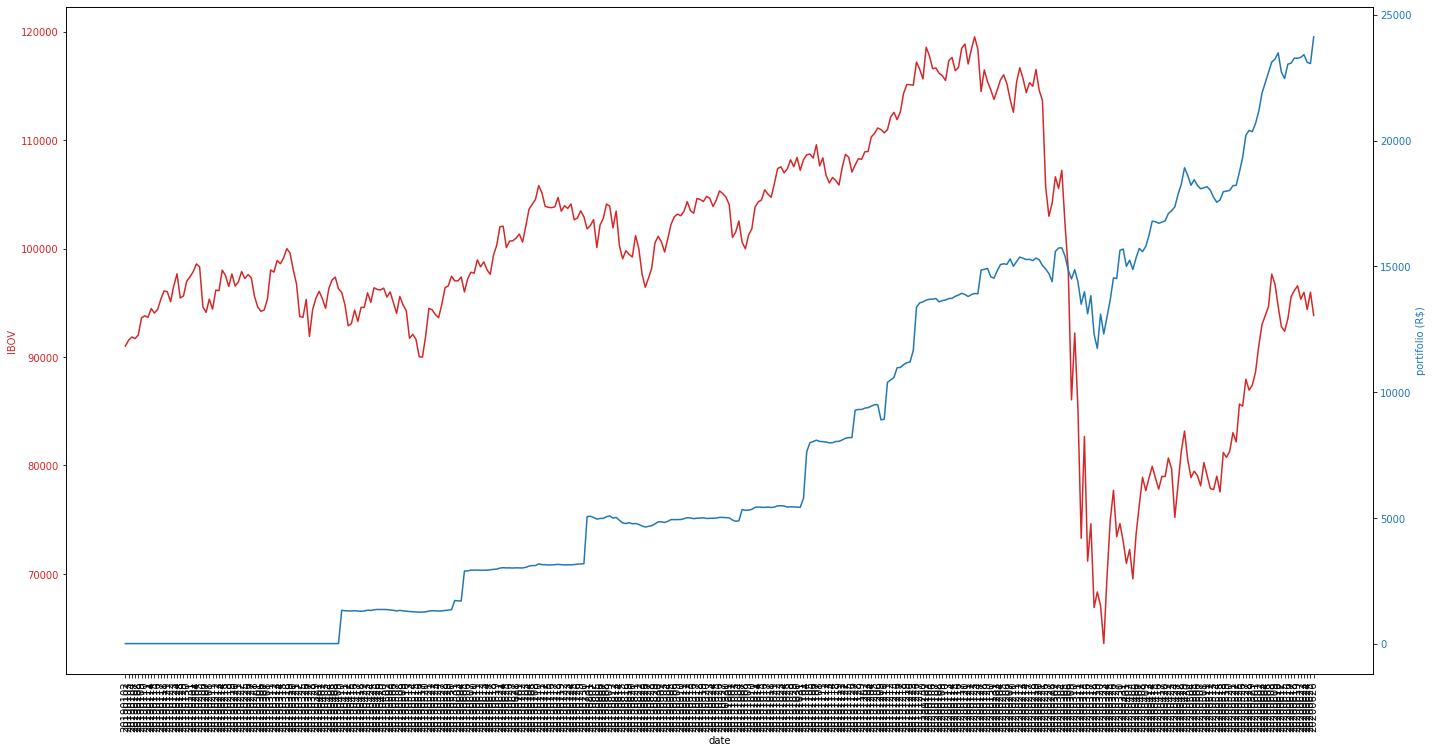

In [23]:
# get IBOV and total portifolio values over time

ibovPoints = []
portValuePoints = []

for day in days:
    ibovPoints.append(ibovData[day].closing)
    portValuePoints.append(dailyportifoliovalue[day])

plotTwoCurves(days, ibovPoints, 'IBOV', portValuePoints, 'portifolio (R$)', undersamplefactor=1)

In [17]:
totalinputmoney = 0
for d in transactions.keys():
    for t in transactions[d]:
        totalinputmoney += (t.buyQtty * t.buyPrice - t.sellQtty * t.sellPrice)
totalinputmoney

23733.79

In [18]:
portValuePoints[-1]

24123.08